<a href="https://colab.research.google.com/github/emmad225/BIACoursework/blob/main/duffyep_lab9_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCI 3397 Lab 9: Object Detection

**Posted:** Friday, April 12, 2024

**Due:** Wednesday, April 17, 2024

__Total Points__: 12 pts

__Submission__: please rename the .ipynb file as __\<your_username\>\_lab9.ipynb__ before you submit it to canvas. Example: weidf_lab9.ipynb.

In [ ]:
# Download images: same as in Lab 9a
! wget https://bc-cv.github.io/csci3397/public/object_detection/test_dog_easy.jpg -O test_dog_easy.jpg
! wget https://bc-cv.github.io/csci3397/public/object_detection/test_dog_hard.jpg -O test_dog_hard.jpg

# Download ImageNet labels
! wget https://bc-cv.github.io/csci3397/public/object_detection/imagenet_classes.txt -O imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

--2024-04-20 17:25:04--  https://bc-cv.github.io/csci3397/public/object_detection/test_dog_easy.jpg
Resolving bc-cv.github.io (bc-cv.github.io)... 185.199.109.153, 185.199.111.153, 185.199.110.153, ...
Connecting to bc-cv.github.io (bc-cv.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44906 (44K) [image/jpeg]
Saving to: ‘test_dog_easy.jpg’

test_dog_easy.jpg   100%[===================>]  43.85K  --.-KB/s    in 0.006s  

2024-04-20 17:25:04 (7.34 MB/s) - ‘test_dog_easy.jpg’ saved [44906/44906]

--2024-04-20 17:25:04--  https://bc-cv.github.io/csci3397/public/object_detection/test_dog_hard.jpg
Resolving bc-cv.github.io (bc-cv.github.io)... 185.199.109.153, 185.199.111.153, 185.199.110.153, ...
Connecting to bc-cv.github.io (bc-cv.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63717 (62K) [image/jpeg]
Saving to: ‘test_dog_hard.jpg’

test_dog_hard.jpg   100%[===================>]  62

<ipython-input-96-f788f680930d>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  dog_easy = imageio.imread('test_dog_easy.jpg')
<ipython-input-96-f788f680930d>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  dog_hard = imageio.imread('test_dog_hard.jpg')


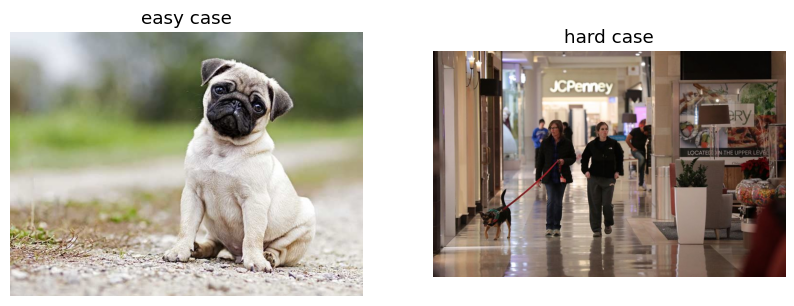

In [ ]:
import imageio
import matplotlib.pyplot as plt

dog_easy = imageio.imread('test_dog_easy.jpg')
dog_hard = imageio.imread('test_dog_hard.jpg')

plt.rcParams["figure.figsize"] = (10,5)
plt.subplot(121)
plt.imshow(dog_easy)
plt.axis('off')
plt.title('easy case')
plt.subplot(122)
plt.imshow(dog_hard)
plt.axis('off')
plt.title('hard case')
plt.show()

Let's try out different pipelines for the hard case above to detect the dog.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Download models
alexnet = torchvision.models.alexnet(pretrained=True)

# <b> 1. Sliding CNN</b>
Let's iterative through the bounding boxes with a certain size (square patch: 151x151) with a fixed stride (71x71). In practice, we need to repeat the computation above for different sizes of bounding boxes.

## (i) Get bounding boxes (sliding window)

<ipython-input-98-16fed066298d>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  dog_hard = imageio.imread('test_dog_hard.jpg')


#row=6, #col=10


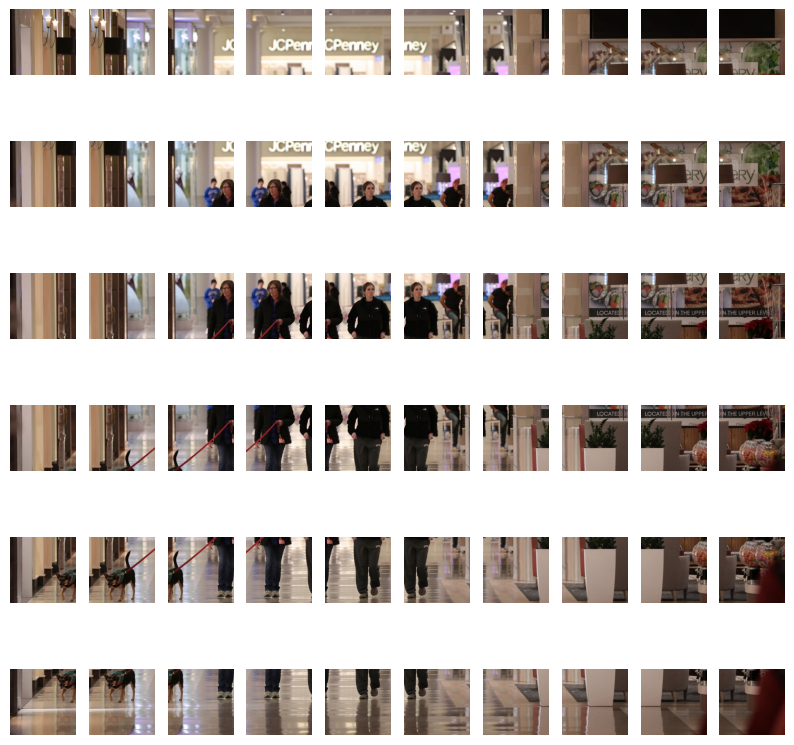

In [ ]:
def imageToPatch(img, row_id, col_id, patch_size, stride_size):
  return img[stride_size*row_id : stride_size*row_id+patch_size,\
             stride_size*col_id : stride_size*col_id+patch_size]

# image to patches
dog_hard = imageio.imread('test_dog_hard.jpg')
im_size = dog_hard.shape
patch_size = 151
stride_size = 71
num_row = (im_size[0] - patch_size) // stride_size + 1
num_col = (im_size[1] - patch_size) // stride_size + 1
print('#row=%d, #col=%d' % (num_row, num_col))

plt.rcParams["figure.figsize"] = (10,10)
count = 1
for y in range(num_row):
  for x in range(num_col):
    plt.subplot(num_row, num_col, count)
    patch = imageToPatch(dog_hard, y, x, patch_size, stride_size)
    plt.imshow(patch)
    plt.axis('off')
    count += 1

plt.show()

## (ii) Preprocess image patches

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# convert image into patches
patches = []
for y in range(num_row):
  for x in range(num_col):
    patch = imageToPatch(dog_hard, y, x, patch_size, stride_size)
    patches.append(preprocess(Image.fromarray(patch)))

im_batch = torch.stack(patches)
print('input batch size:', im_batch.shape)

input batch size: torch.Size([60, 3, 224, 224])


## (iii) Run inference

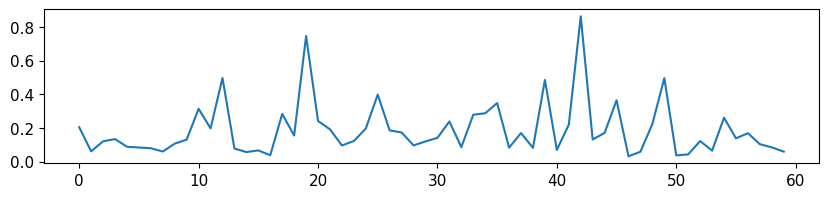

In [ ]:
pred = alexnet(im_batch)
prob = F.softmax(pred, dim=1).detach().numpy()
prob_max = prob.max(axis=1)


# plot the top probability for each patch
plt.rcParams["figure.figsize"] = (10,2)
plt.plot(prob_max)

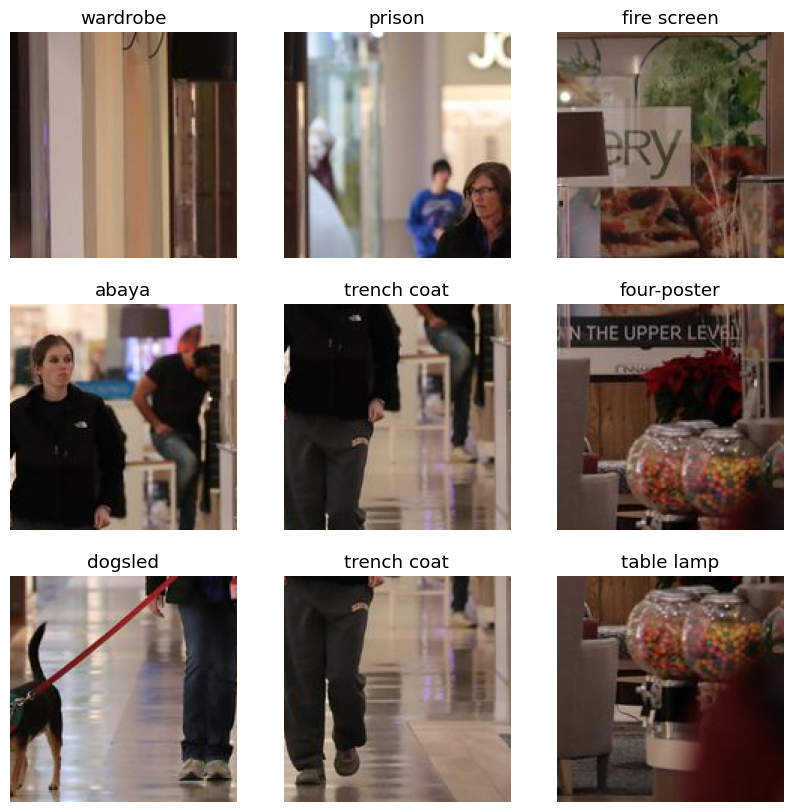

In [ ]:
# let's see what does it detect for the most confident patch
pos_ids = np.where(prob_max > 0.3)[0]
row_ids = pos_ids // num_col
col_ids = pos_ids - row_ids * num_col

plt.rcParams["figure.figsize"] = (10,10)
for i in range(len(pos_ids)):
  plt.subplot(3,3,i+1)
  patch = imageToPatch(dog_hard, row_ids[i], col_ids[i], patch_size, stride_size)
  plt.imshow(patch)
  plt.axis('off')
  plt.title(categories[np.argmax(prob[pos_ids[i]])])

# <b>2. R-CNN</b>


## (i) Get bounding boxes (selective search)

In [ ]:
# cv2 reads in images as BGR; pytorch pretrain models take RGB input
# create a new variable to avoid confusion...
dog_hard_cv2 = cv2.imread('test_dog_hard.jpg')
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(dog_hard_cv2)
ss.switchToSelectiveSearchFast()
# rects: Nx4 matrix
# each row: x,y,w,h
rects = ss.process()
print('Selective search: find %d boxes' % rects.shape[0])

Selective search: find 4782 boxes


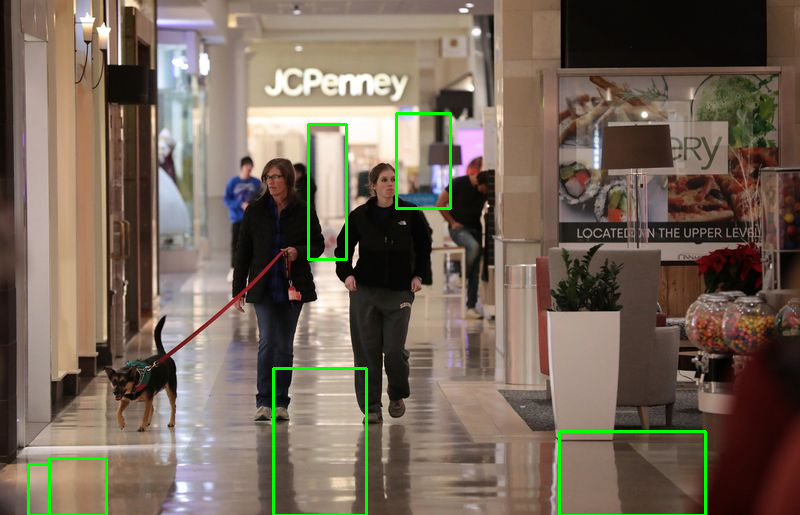

In [ ]:
# plot the top 6 bounding boxes
image = cv2.rectangle(dog_hard_cv2.copy(), tuple(rects[0,:2]), tuple(rects[0,:2]+rects[0,2:]), (0,255,0), 2)
for i in range(1, 6):
  image = cv2.rectangle(image, tuple(rects[i,:2]), tuple(rects[i,:2]+rects[i,2:]), (0,255,0), 2)
cv2_imshow(image)

## (ii) Preprocess image patches

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)), # scale the both sides to 224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# take every 8 bounding boxes
rects_sub = rects[::8]
patches = [None] * rects_sub.shape[0]
for i in range(len(patches)):
  x,y,w,h = rects_sub[i]
  patches[i] = preprocess(Image.fromarray(dog_hard[y:y+h, x:x+w]))

im_batch = torch.stack(patches)
print('input batch size:', im_batch.shape)

input batch size: torch.Size([598, 3, 224, 224])


## (iii) [4 pts] Exercise 1: Run inference
Repeat the code in `(1,i) Sliding CNN` to plot the top-1 prediction for all the patches

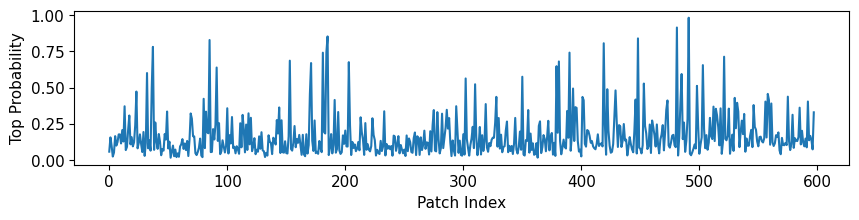

In [ ]:
#### Your code starts here ####
#Compute the top-class probability for each patch
def compute_top_class_probabilities(model, patches):
    device = next(model.parameters()).device
    patches = patches.to(device)

    with torch.no_grad():
        outputs = model(patches)

    probabilities = F.softmax(outputs, dim=1)
    top_probabilities, _ = torch.max(probabilities, dim=1)
    return top_probabilities.cpu().numpy()

top_probabilities = compute_top_class_probabilities(alexnet, im_batch)

# Plot the top probability for each patch
plt.rcParams["figure.figsize"] = (10,2)
plt.plot(top_probabilities)
plt.xlabel('Patch Index')
plt.ylabel('Top Probability')
plt.show()

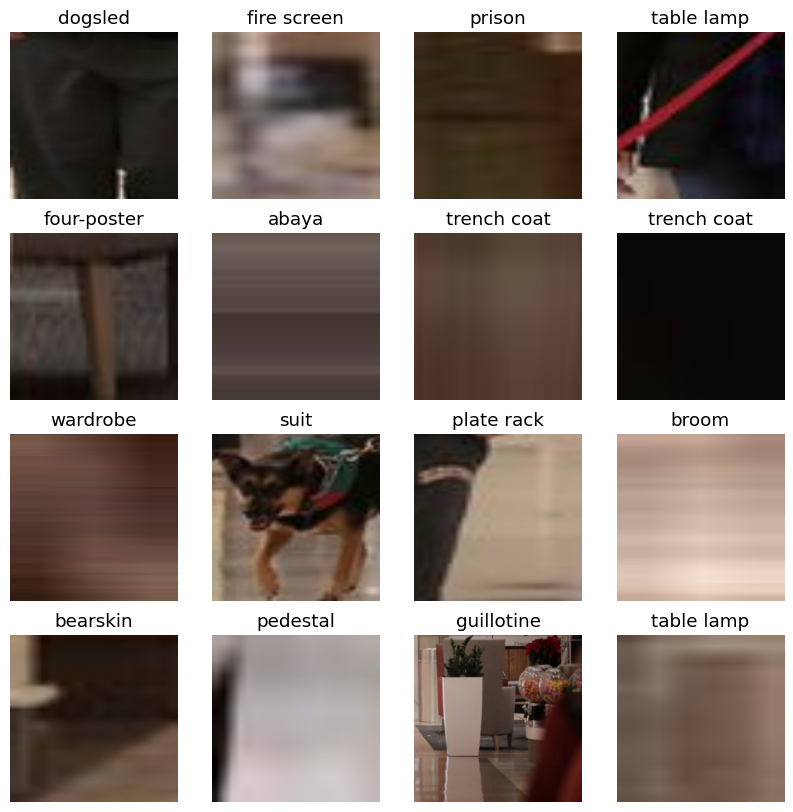

In [ ]:
# let's see what does it detect for the most confident patch
pos_sort = np.argsort(-prob_max)

plt.rcParams["figure.figsize"] = (10,10)
for i in range(16):
  plt.subplot(4,4,i+1)
  x,y,w,h = rects_sub[pos_sort[i]]
  patch = dog_hard[y:y+h, x:x+w]
  plt.imshow(cv2.resize(patch,(224,224)))
  plt.axis('off')
  plt.title(categories[np.argmax(prob[pos_sort[i]])])

In [ ]:
rects_sub_pt = torch.as_tensor(np.hstack([rects_sub[:,:2], rects_sub[:,:2]+rects_sub[:,2:]]).astype(np.float32))
idx = torchvision.ops.nms(rects_sub_pt, torch.as_tensor(prob_max), 0.1)

plt.rcParams["figure.figsize"] = (10,10)
for i in range(16):
    plt.subplot(4,4,i+1)
    if i < len(idx):
        x,y,w,h = rects_sub[idx[i]]
        patch = dog_hard[y:y+h, x:x+w]
        plt.imshow(cv2.resize(patch,(224,224)))
        plt.axis('off')
        plt.title(categories[np.argmax(prob[idx[i]])])
    else:
        plt.axis('off')

RuntimeError: boxes and scores should have same number of elements in dimension 0, got 598 and 60

# <b> 3. Fast/Faster R-CNN (Detectron2!)</b>

## (i) Install Detectron2

Remember to restart the runtime after the following installation. Click the "restart runtime" button in the code block output.

In [ ]:
# !pip install pyyaml==5.3.1
# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
!pip install torch==2.2.1+cu121 torchvision==0.17.1+cu121 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-4fswyslf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-4fswyslf
  Resolved https://github.com/facebookresearch/detectron2.git to commit a59f05630a8f205756064244bf5beb8661f96180
  Preparing metadata (setup.py) ... done


## (ii) Run inference

In [ ]:
# check pytorch installation:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
#assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

2.2.1+cu121 True


In [ ]:
cfg = get_cfg()
cfg.INPUT.FORMAT = 'RGB'
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
predictor = DefaultPredictor(cfg)

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library

#cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

[04/20 17:26:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_C4_3x/137849393/model_final_f97cb7.pkl ...


In [ ]:
import imageio
dog_hard = imageio.imread('test_dog_hard.jpg')
outputs = predictor(dog_hard)

<ipython-input-4-77be1f7b218b>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  dog_hard = imageio.imread('test_dog_hard.jpg')
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# examine what's in the output: {bounding box, class probability, detection confidence}
outputs['instances'].__dict__['_fields'].keys()

dict_keys(['pred_boxes', 'scores', 'pred_classes'])

In [ ]:
import matplotlib.pyplot as plt

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(dog_hard, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.rcParams["figure.figsize"] = (30,30)
plt.imshow(out.get_image())
plt.axis('off')
plt.show()

## (iii) Model examination
Given a pytorch model, we can examine the following two aspects:
- Layer: how the lego pieces are organized into blocks
- Feature maps: output size of specific layers

### (a) Layer examination

As we've learned, one neural network can have hundreds of layers. Thus, the layers are further grouped into computation blocks for a better organization.

In [ ]:
# print all module names (look for the top-level hierarchy)
predictor.model._modules

OrderedDict([('backbone',
              ResNet(
                (stem): BasicStem(
                  (conv1): Conv2d(
                    3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
                    (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
                  )
                )
                (res2): Sequential(
                  (0): BottleneckBlock(
                    (shortcut): Conv2d(
                      64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
                      (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
                    )
                    (conv1): Conv2d(
                      64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
                      (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
                    )
                    (conv2): Conv2d(
                      64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
                      (norm): FrozenBatchNorm2d(n

In [ ]:
predictor.model._modules.keys()

odict_keys(['backbone', 'proposal_generator', 'roi_heads'])

Thus, here are the name of modules on the top-level hierarchy in the model:
```
Faster-RCNN:
- backbone
- proposal_generator
- roi_heads
```

As learned in class, given the image feature map from `backbone`, `prorposal_generator` predicts possible bounding boxes and `roi_reads` crops+resizes the feature map for each bounding box and predict the class probability for the object inside the box.

### (b) Feature map examination

To save memory, pytorch doesn't save the intermediate layer output (feature maps) by default. We can apply the `register_forward_hook()` function to the layer for examination.

For example, to check the size of the feature map of the **backbone**, we can look into its last computation block (second-level layer blocks) `res4` as follows:

In [ ]:
## code to show modules for the Detectron2 model
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

predictor.model._modules['backbone']._modules['res4'].register_forward_hook(get_activation('res4'))
outputs = predictor(dog_hard)

print('res4-block output feature size: ', activation['res4'].shape)

res4-block output feature size:  torch.Size([1, 1024, 50, 78])


# <b> 4. YOLO </b>

## (i) Install YOLO

In [ ]:
! pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  # install dependencies

## (ii) Run inference

In [ ]:
import torch

# Model
model_yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Images
imgs = ['https://bc-cv.github.io/csci3397/public/object_detection/test_dog_hard.jpg']  # batch of images

# Inference
results = model_yolo(imgs)
results_np = results.xyxy[0].detach().cpu().numpy().astype(int)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-4-20 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


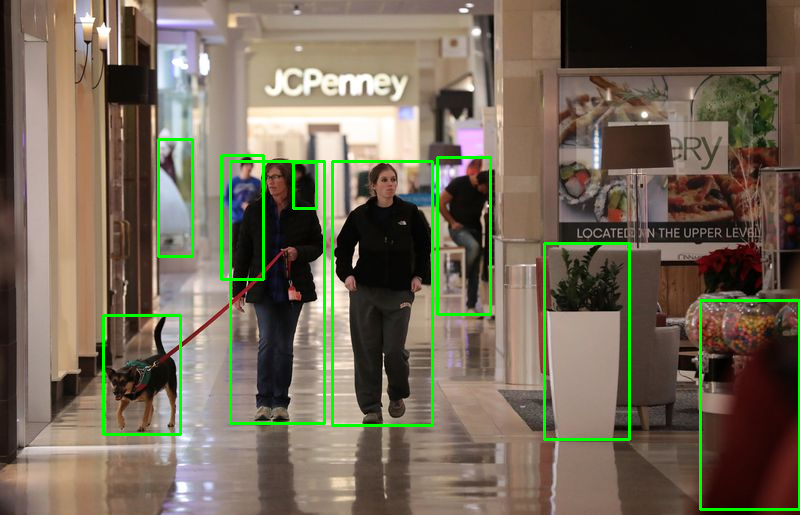

In [ ]:
# plot the top 6 bounding boxes
image = cv2.rectangle(cv2.imread('test_dog_hard.jpg'), tuple(results_np[0,:2]), tuple(results_np[0,2:4]), (0,255,0), 2)
for i in range(1, results_np.shape[0]):
  image = cv2.rectangle(image, tuple(results_np[i,:2]), tuple(results_np[i,2:4]), (0,255,0), 2)
cv2_imshow(image)

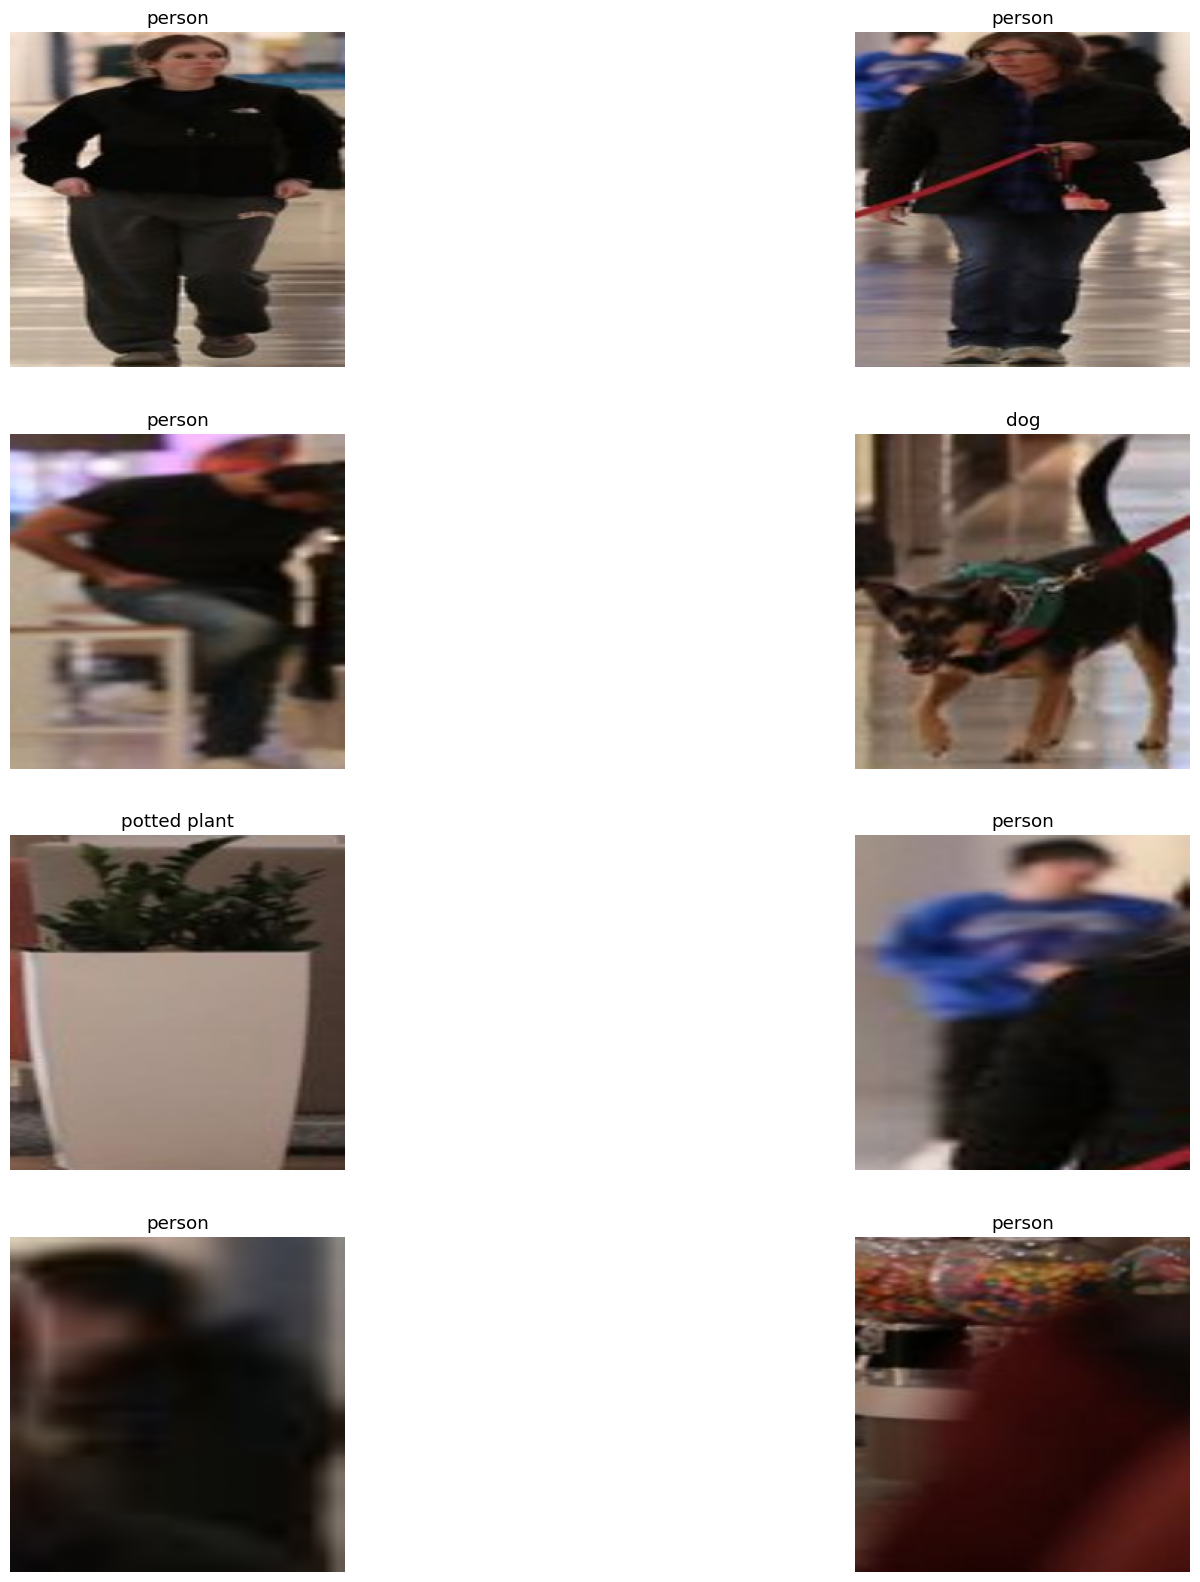

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,20)
for i in range(8):
  plt.subplot(4,2,i+1)
  x1,y1,x2,y2,sc, cls = results_np[i]
  patch = dog_hard[y1:y2, x1:x2]
  # cv2_imshow uses BGR instead of RGB...
  # cv2_imshow(cv2.resize(patch,(224,224))[:,:,::-1])
  plt.imshow(cv2.resize(patch,(224,224)))
  plt.axis('off')
  plt.title(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes[int(cls)])
plt.show()

## [4 pts] Exercise 2.1: Layer examination
List the name of modules on the top-level hierarchy in the model.

In [ ]:
model_yolo._modules['model']._modules['model']._modules['model']._modules

OrderedDict([('0',
              Conv(
                (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
                (act): SiLU(inplace=True)
              )),
             ('1',
              Conv(
                (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
                (act): SiLU(inplace=True)
              )),
             ('2',
              C3(
                (cv1): Conv(
                  (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
                  (act): SiLU(inplace=True)
                )
                (cv2): Conv(
                  (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
                  (act): SiLU(inplace=True)
                )
                (cv3): Conv(
                  (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
                  (act): SiLU(inplace=True)
                )
                (m): Sequential(
                  (0): Bottleneck(
                 

In [ ]:
model_yolo._modules['model']._modules['model']._modules['model']._modules.keys()

odict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'])

YOLO
```
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24

```


## [4 pts] Exercise 2.2: Data examination

Print the size of the output of the `24`-th module.

Hint:
- use `._modules.keys()` to make sure you are registrating the hook to the module_list instead of a tuple/dictionary.
- if you make a mistake for the hook registeration, you may need to reload the model to start over.
- note that as the `__forward__()` function has more processing, the output from `model_yolo(im)` is different from the raw output of the last computational block (module list).

In [ ]:
#I couldn't get it to work not using a dictionary/tuple 🙃
activation = {}

def hook(module, input, output):
    activation['yolo_out'] = output[0] if isinstance(output, tuple) else output

module_24 = model_yolo._modules['model']._modules['model']._modules['model']._modules['24']

hook_handle = module_24.register_forward_hook(hook)

_ = model_yolo(torch.rand(1, 3, 640, 640))

print('output of the 24th module: ', activation['yolo_out'].shape)

output of the 24th module:  torch.Size([1, 25200, 85])
